In [ ]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import modeling_utils as utils

In [131]:
# some code for prettier plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 16,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6),
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 8,
                     'ytick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.minor.size': 4})

### Data
This data consists of Marla's homoegenous reduction of Keck/DEIMOS spectroscopy for the Milky Way satellites (Geha+2025). There are three files we will be using, each at a different scale:
- table2_systems : one row per system
- table4_stars : one row per star
- KOA_table_one_row_per_star_per_mask : one row per epoch

We will quickly clean the data to only include Milky Way dwarf galaxies.

In [132]:
# open systems data
systems  = pd.read_csv("table2_systems.csv")
systems  = systems[(systems["Type"] == "G") & (systems["sigma"] > 0) & (systems["N_mem"] > 10)] # only keep dgs
systems  = systems.sort_values(by = "Name2")
systems = systems.reset_index(drop = True)
systems["Galaxy_idx"] = np.arange(0, len(systems))

# galaxy names
galaxies = np.unique(systems["Name2"])
gal_idx  = {name: i for i, name in enumerate(galaxies)}

# open stars data, only keep dgs
stars = pd.read_csv("table4_stars.csv")
stars = stars[stars["Galaxy"].isin(galaxies)]
stars["Galaxy_idx"] = np.array([gal_idx[ii] for ii in stars["Galaxy"]])

# open multi-epoch data, only keep dgs
stars_multiple_tab = Table.read("KOA_table_one_row_per_star_per_mask.fits")
stars_multiple     = stars_multiple_tab.to_pandas()
stars_multiple['system_name'] = stars_multiple['system_name'].str.decode('utf-8')
stars_multiple     = stars_multiple[stars_multiple["system_name"].isin(galaxies)]
stars_multiple["Galaxy_idx"] = np.array([gal_idx[ii] for ii in stars_multiple["system_name"]])

print(len(galaxies))

27


In [133]:
stars_multiple.columns

Index(['system_name', 'maskname', 'mask_mjd', 'nmask', 'slitname', 'objname',
       'RA', 'DEC', 'phot_source', 'gmag_o', 'rmag_o', 'gmag_err', 'rmag_err',
       'MV_o', 'mask_SN', 'mask_teff', 'mask_serendip', 'mask_coadd_flag',
       'mask_marz_flag', 'mask_v', 'mask_v_err', 'mask_marz_z', 'mask_ew_cat',
       'mask_ew_cat_err', 'mask_ew_naI', 'mask_ew_naI_err', 'mask_ew_mgI',
       'mask_ew_mgI_err', 'mask_ew_feh', 'mask_ew_feh_err', 'flag_HB',
       'mask_collate1d_filename', 'Galaxy_idx'],
      dtype='object')

In [134]:
stars.columns

Index(['Galaxy', 'RA', 'DEC', 'r', 'gr', 'nmask', 't_exp', 'SN', 'v', 'verr',
       'CaT', 'CaTerr', 'FeH', 'FeH_err', 'Var', 'Pmem', 'Galaxy_idx'],
      dtype='object')

In [135]:
systems.columns

Index(['Name', 'Name2', 'RA', 'Dec', 'Dist', 'MV', 'R_eff', 'Type', 'Phot',
       'N_mask', 'N_mem', 'vhel', 'vhelerr', 'sigma', 'serr_low', 'serr_up',
       'serr_95', 'Galaxy_idx'],
      dtype='object')

### Data Wrangling
First, we will determine the half-light radius of each star for its respective satellite. Next, we will match the stars in the multiple epoch catalog to the single-star catalog and only keep those associated with Milky Way dwarf galaxies.

In [136]:
for gg in galaxies:
    # get system info
    row = systems[systems["Name2"] == gg]
    ra, dec, rhalf = row["RA"].values[0], row["Dec"].values[0], row["R_eff"].values[0] / 60

    # get stars in system
    s_rows = stars[stars["Galaxy"] == gg]
    x_ra = (s_rows["RA"].values - ra) * np.cos(np.deg2rad(dec))
    y_dec = (s_rows["DEC"].values - dec)
    r = (x_ra ** 2 + y_dec ** 2) ** (1/2)
    n_rhalf = r / rhalf
    
    stars.loc[stars["Galaxy"] == gg, "rhalf"] = n_rhalf
    stars.loc[stars["Galaxy"] == gg, "s_idx"] = np.arange(0, len(s_rows))

In [137]:
# astropy coordinates of munoz, full deimos data
c_phot = SkyCoord(stars_multiple["RA"], stars_multiple["DEC"], unit = u.degree)
c_deimos = SkyCoord(stars["RA"], stars["DEC"], unit = u.degree)

# matching criteria within 1 arcsec
index, d2d, d3d = c_phot.match_to_catalog_sky(c_deimos)
foo = np.arange(0, np.size(index), 1)
match_phot = foo[d2d < 1.*u.arcsec]
match_deimos = index[d2d < 1.*u.arcsec]

# new df with matched munoz/full deimos data
phot_data_match = stars_multiple.iloc[match_phot]
deimos_data_match = stars.iloc[match_deimos]
deimos_phot_combined = pd.concat([phot_data_match, deimos_data_match.set_axis(phot_data_match.index)], axis = 1)

print("{} matches out of {} deimos sources.".format(len(deimos_phot_combined), len(stars_multiple)))

12732 matches out of 14476 deimos sources.


In [310]:
stars_epochs = deimos_phot_combined[["Galaxy", "RA", "DEC", "r", "gr", "mask_v", "mask_v_err", "FeH", "FeH_err", "Var", "Pmem", "Galaxy_idx", "rhalf", "s_idx"]]
stars_epochs = stars_epochs.loc[:, ~stars_epochs.columns.duplicated()]

### 1. Regular MCMC of individual galaxies
We will start by performing a standard Gaussian MCMC algorithm on our dwarf galaxy sample to estimate its systemic velocity, velocity dispersion, mean metallicity, and metallicity spread. From these empirical distributions, we can be better informed about the model form that the different levels of our hierarchical model should take (e.g. hyperpriors).

In [579]:
for ii in range(len(galaxies)):
    gal_name = galaxies[ii]
    gal_bin = stars[(stars["Galaxy"] == gal_name) & (stars["Pmem"] != 0) & (stars["rhalf"] <= 2) & (stars["Var"] == 1)]

    systems.loc[ii, "n_binary"]   = len(gal_bin)

In [ ]:
for ii in range(len(galaxies)):
    gal_name = galaxies[ii]
    gal_tot = stars[(stars["Galaxy"] == gal_name) & (stars["Pmem"] != 0) & (stars["rhalf"] <= 2)] # (stars["Var"] != 1) & 
    gal = stars[(stars["Galaxy"] == gal_name) & (stars["Pmem"] > 0.5) & (stars["Var"] != 1) & (stars["rhalf"] <= 2)]
    gal_feh = gal[gal["FeH"] > -10]
    gal_global = systems[systems["Name2"] == gal_name]
    print(ii, len(gal), gal_global["vhel"].values, gal_global["sigma"].values)

    if len(gal) > 10:
        model, trace, summary, fig, vr_vals, sigma_vals = utils.velocity_mcmc(gal["v"].values, gal["verr"].values, vr_guess = gal_global["vhel"].values[0], sig_guess = gal_global["sigma"].values[0])
        model, trace, summary, fig, feh_vals, sigma_feh_vals = utils.feh_mcmc(gal_feh["FeH"].values, gal_feh["FeH_err"].values, vr_guess = np.median(gal_feh["FeH"].values), sig_guess = np.std(gal_feh["FeH"].values))
    else:
        vr_vals, sigma_vals = [np.nan, np.nan, np.nan], [np.nan, np.nan, np.nan]
    
    systems.loc[ii, "vsys_1"]   = vr_vals[1]
    systems.loc[ii, "vsys_1ep"] = vr_vals[2] - vr_vals[1]
    systems.loc[ii, "vsys_1em"] = vr_vals[1] - vr_vals[0]

    systems.loc[ii, "vdisp_1"]   = sigma_vals[1]
    systems.loc[ii, "vdisp_1ep"] = sigma_vals[2] - sigma_vals[1]
    systems.loc[ii, "vdisp_1em"] = sigma_vals[1] - sigma_vals[0]

    systems.loc[ii, "feh_1"]   = feh_vals[1]
    systems.loc[ii, "feh_1ep"] = feh_vals[2] - feh_vals[1]
    systems.loc[ii, "feh_1em"] = feh_vals[1] - feh_vals[0]

    systems.loc[ii, "fehdisp_1"]   = sigma_feh_vals[1]
    systems.loc[ii, "fehdisp_1ep"] = sigma_feh_vals[2] - sigma_feh_vals[1]
    systems.loc[ii, "fehdisp_1em"] = sigma_feh_vals[1] - sigma_feh_vals[0]

    systems.loc[ii, "Nstar"] = len(gal)
    systems.loc[ii, "Nstar_tot"] = len(gal_tot)
    systems.loc[ii, "Nstar_feh"] = len(gal_feh)

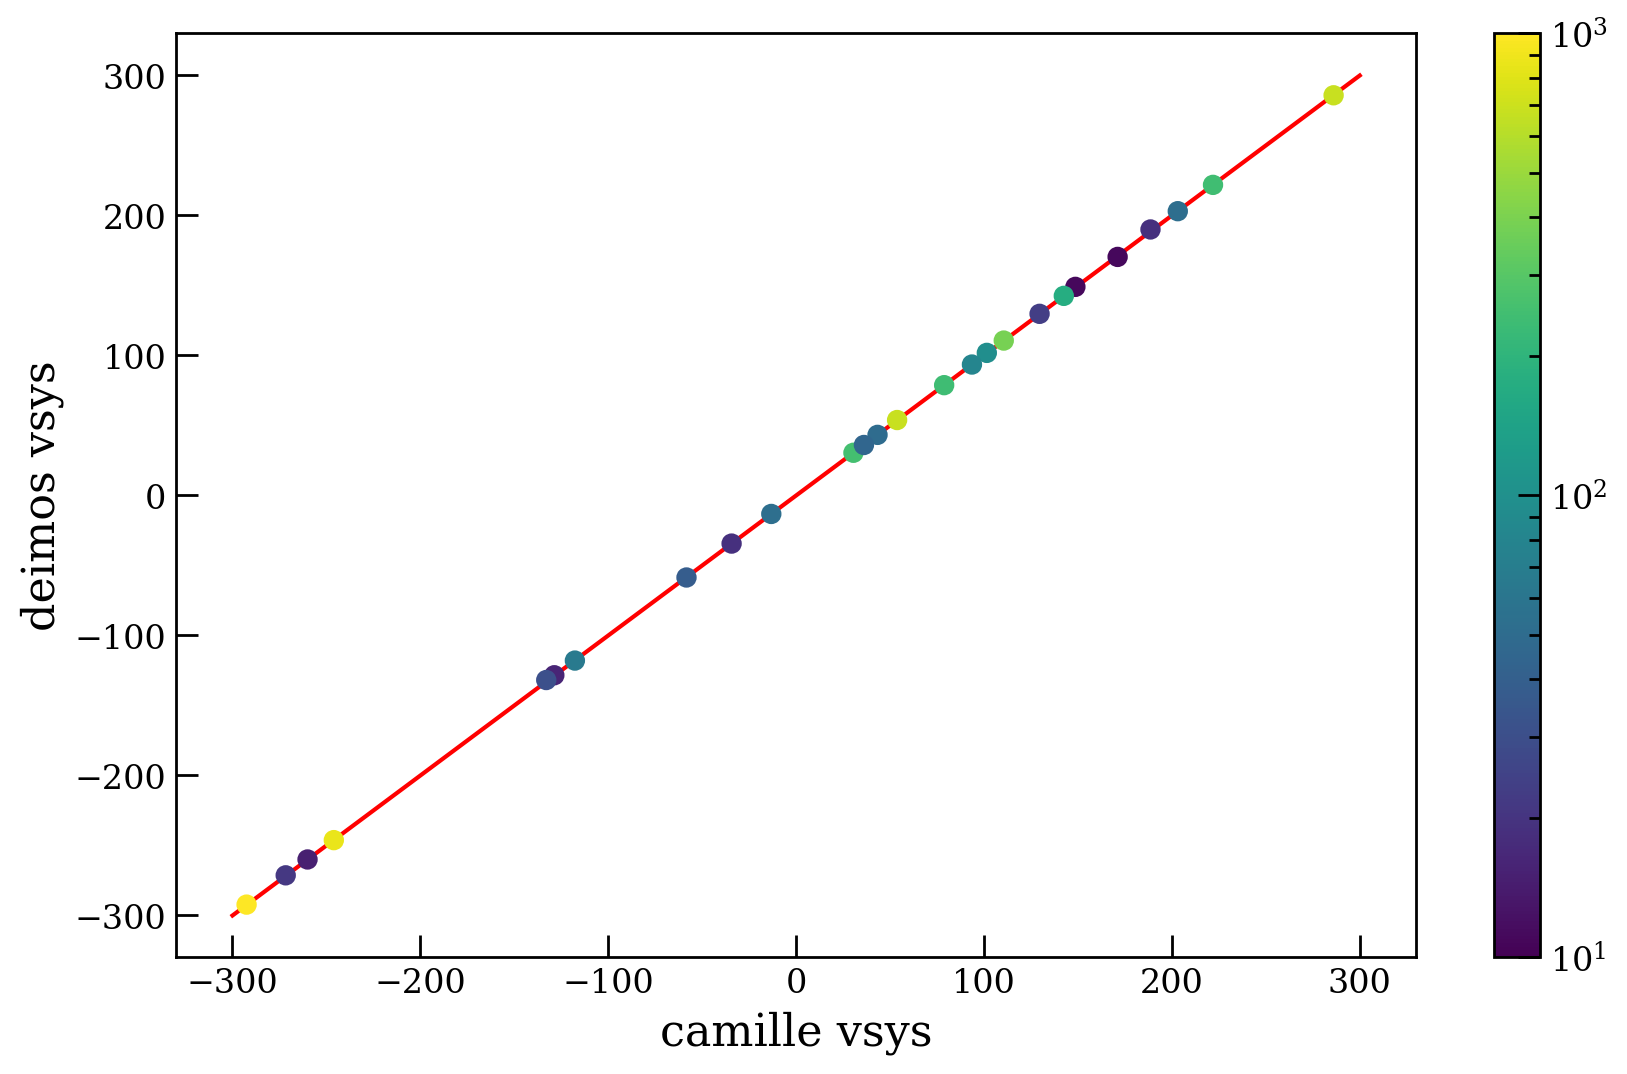

In [587]:
### double check with marla values
plt.errorbar(systems["vsys_1"], systems["vhel"], xerr = np.array([systems["vsys_1ep"], systems["vsys_1em"]]), 
             yerr = systems["vhelerr"], fmt = "o", c = "black", ms = 2, zorder = 0)
plt.scatter(systems["vsys_1"], systems["vhel"], c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([-300, 300], [-300, 300], c = "red", zorder = 0)
plt.xlabel("camille vsys")
plt.ylabel("deimos vsys")
plt.colorbar()

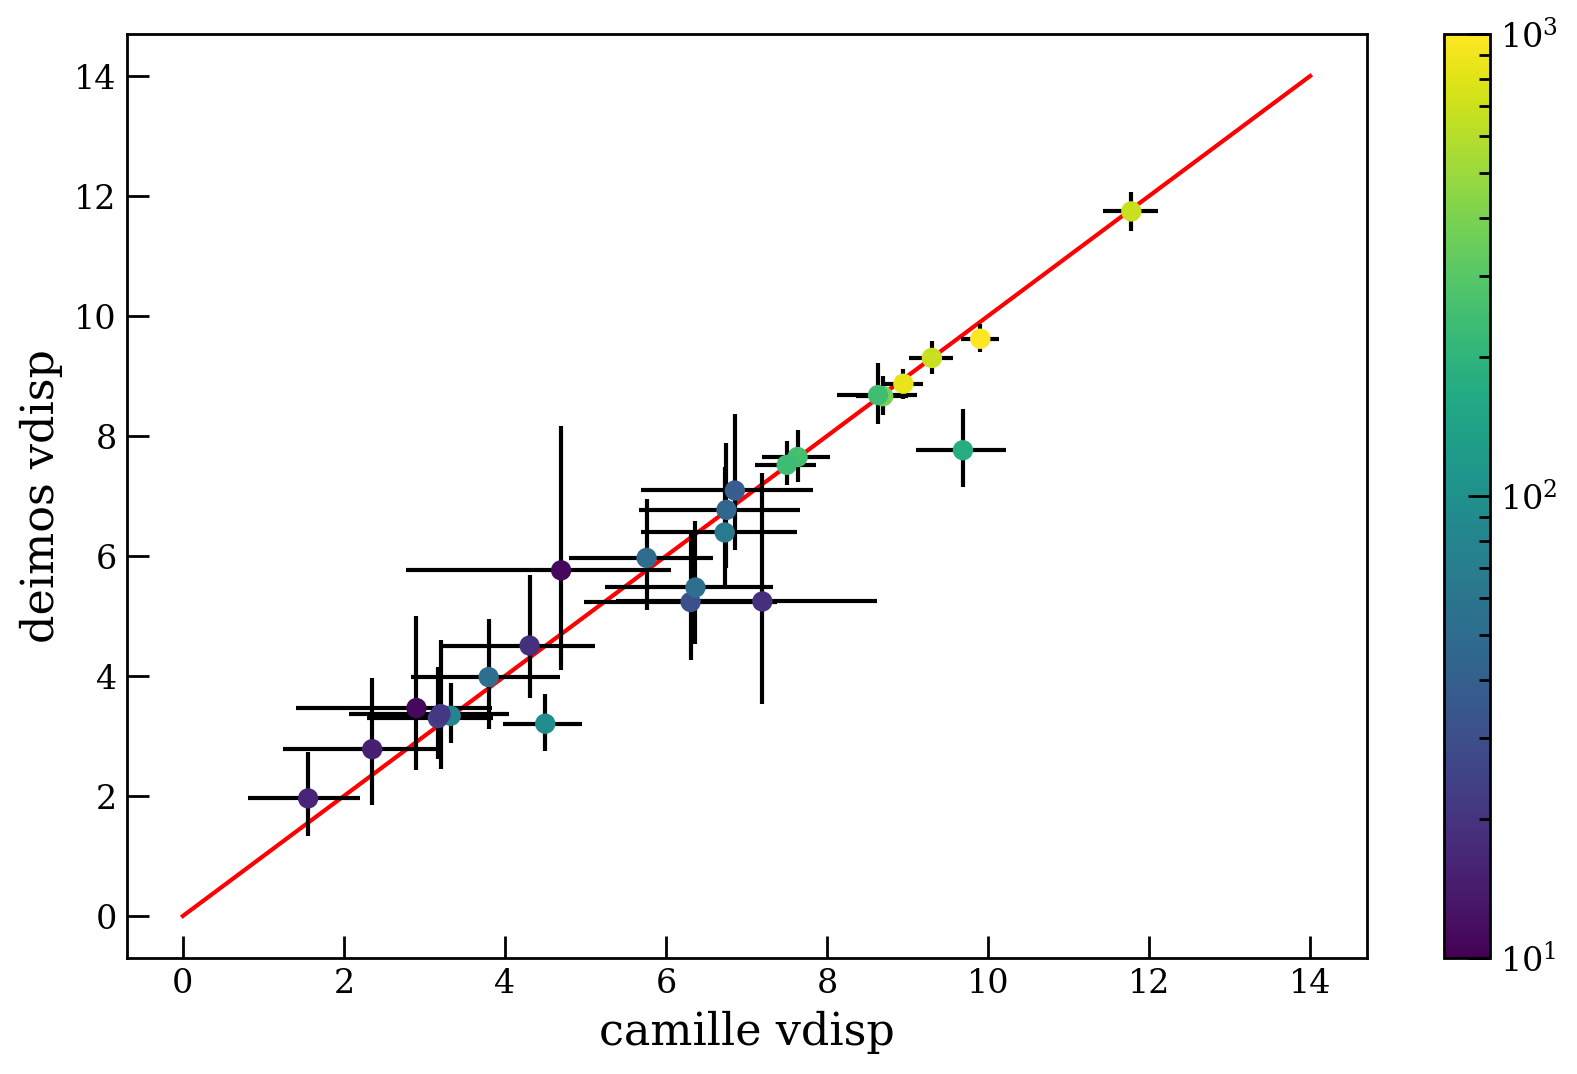

In [ ]:
### double check with marla values
plt.errorbar(systems["vdisp_1"], systems["sigma"], xerr = np.array([systems["vdisp_1ep"], systems["vdisp_1em"]]), 
             yerr = np.array([systems["serr_low"], systems["serr_up"]]), fmt = "o", c = "black", ms = 2, zorder = 1)
plt.scatter(systems["vdisp_1"], systems["sigma"], c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([0, 14], [0, 14], c = "red", zorder = 0)
plt.xlabel("camille vdisp")
plt.ylabel("deimos vdisp")
plt.colorbar()

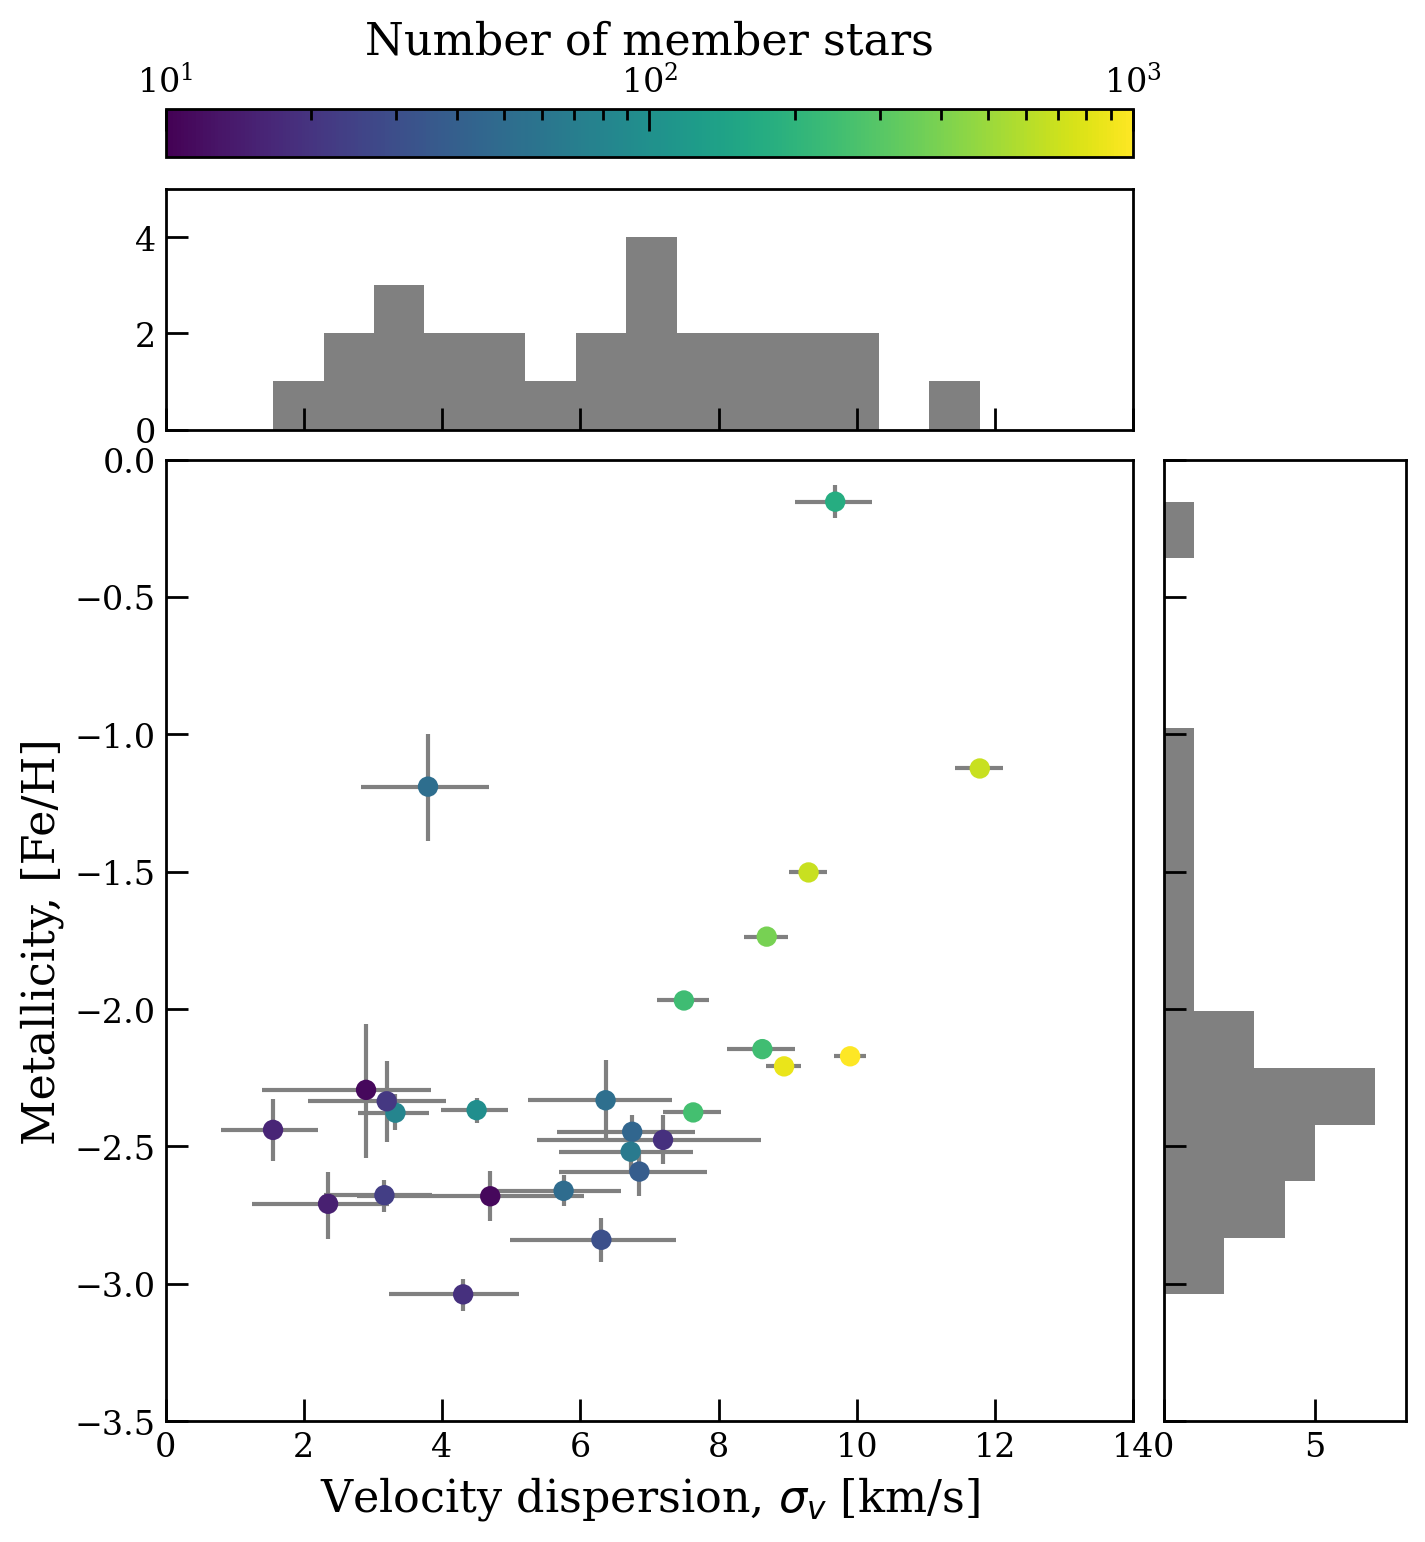

In [591]:
# figure
fig, ax = plt.subplots(2, 2, figsize = (8, 8), gridspec_kw = {"width_ratios": [4, 1], "height_ratios": [1, 4], "wspace": 0.05, "hspace": 0.05})
ax[0, 1].axis("off")
ax[0, 0].sharex(ax[1, 0])
ax[1, 1].sharey(ax[1, 0])

# scatter
ax[1, 0].errorbar(systems["vdisp_1"], systems["feh_1"], xerr = np.array([systems["vdisp_1ep"], systems["vdisp_1em"]]), 
                  yerr = np.array([systems["feh_1ep"], systems["feh_1em"]]), fmt = "o", c = "grey", ms = 2, zorder = 0)
data = ax[1, 0].scatter(systems["vdisp_1"], systems["feh_1"], c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), s = 40, zorder = 1)

ax[1, 0].set_xlabel(r"Velocity dispersion, $\sigma_v$ [km/s]")
ax[1, 0].set_ylabel(r"Metallicity, [Fe/H]")
ax[1, 0].set_xlim(0, 14)
ax[1, 0].set_ylim(-3.5, 0)

# histogram
ax[0, 0].hist(systems["vdisp_1"], bins = 14, color = "grey")
ax[1, 1].hist(systems["feh_1"], bins = 14, orientation = "horizontal", color = "grey")
plt.setp(ax[0, 0].get_xticklabels(), visible = False)
plt.setp(ax[1, 1].get_yticklabels(), visible = False)

ax[0, 0].set_ylim(0, 5)
ax[1, 1].set_xlim(0, 8)

pos = ax[0, 0].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y1 + 0.02, pos.width, 0.03])
cb = fig.colorbar(data, cax = cbar_ax, orientation = "horizontal")
cb.set_label("Number of member stars")
cb.ax.xaxis.set_label_position("top")
cb.ax.xaxis.tick_top()

### 2. Adding population level hyperpriors

In [ ]:
gals = stars[(stars["Pmem"] > 0.5) & (stars["Var"] != 1) & (stars["rhalf"] <= 2)]
model, trace, summary, mu_vr_vals, tau_vr_vals, mu_sig_vals, tau_sig_vals, v_r_percentiles, sigma_v_percentiles = utils.velocity_mcmc2(gals["v"].values, gals["verr"].values, gals["Galaxy_idx"].values)

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vr, log_tau_vr, mu_sig, log_tau_sig, v_r, sigma_v]
INFO:pymc.sampling.mcmc:NUTS: [mu_vr, log_tau_vr, mu_sig, log_tau_sig, v_r, sigma_v]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 152 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 152 seconds.


In [480]:
systems["2vsys"] = v_r_percentiles[:, 1]
systems["2vsys_ep"] = v_r_percentiles[:, 1] - v_r_percentiles[:, 0]
systems["2vsys_em"] = v_r_percentiles[:, 2] - v_r_percentiles[:, 1]

systems["2vdisp"] = sigma_v_percentiles[:, 1]
systems["2vdisp_ep"] = sigma_v_percentiles[:, 1] - sigma_v_percentiles[:, 0]
systems["2vdisp_em"] = sigma_v_percentiles[:, 2] - sigma_v_percentiles[:, 1]

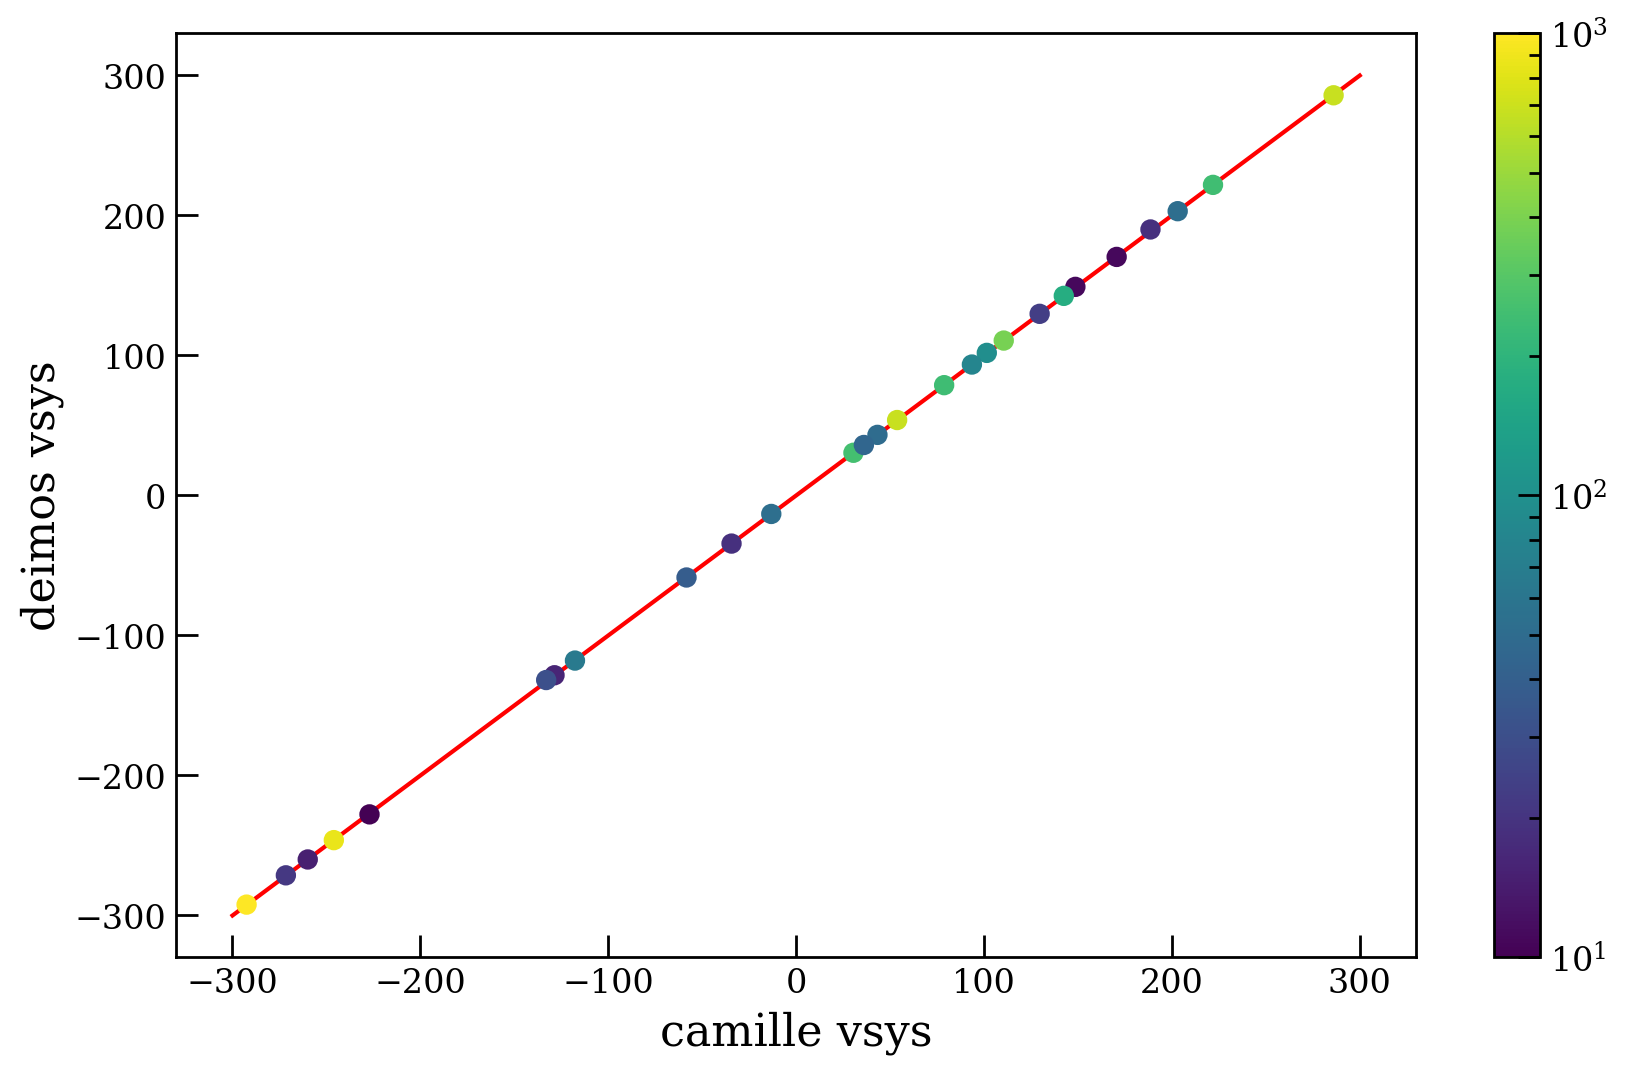

In [ ]:
plt.errorbar(systems["2vsys"], systems["vhel"], xerr = np.array([systems["2vsys_ep"], systems["2vsys_em"]]), 
             yerr = systems["vhelerr"], fmt = "o", c = "black", ms = 2, zorder = 0)
plt.scatter(systems["2vsys"], systems["vhel"], c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([-300, 300], [-300, 300], c = "red", zorder = 0)
plt.xlabel("camille vsys")
plt.ylabel("deimos vsys")
plt.colorbar()

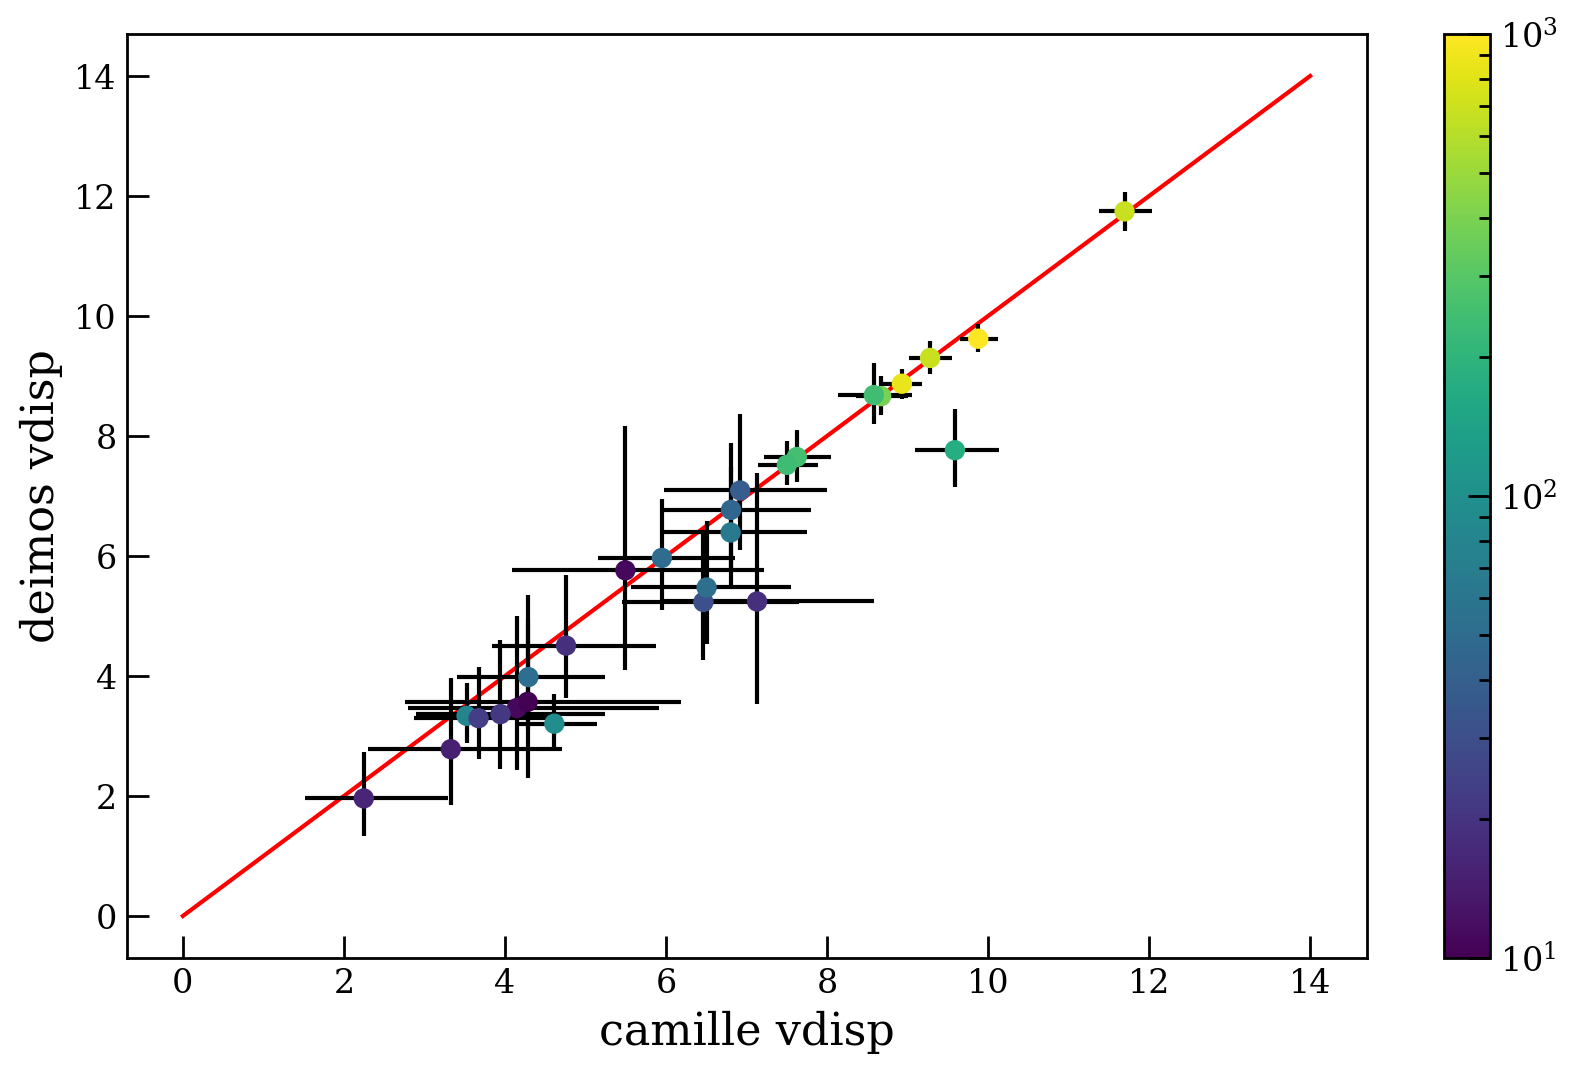

In [482]:
plt.errorbar(systems["2vdisp"], systems["sigma"], xerr = np.array([systems["2vdisp_ep"], systems["2vdisp_em"]]), 
             yerr = np.array([systems["serr_low"], systems["serr_up"]]), fmt = "o", c = "black", ms = 2, zorder = 1)
plt.scatter(systems["2vdisp"], systems["sigma"], c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([0, 14], [0, 14], c = "red", zorder = 0)
plt.xlabel("camille vdisp")
plt.ylabel("deimos vdisp")
plt.colorbar()

### 3. Add MW foreground contamination fraction

In [ ]:
gal = stars[(stars["Var"] != 1) & (stars["rhalf"] <= 2)]
model, trace, mu_vr_vals, tau_vr_vals, mu_sig_vals, tau_sig_vals, v_r_percentiles, sigma_v_percentiles = utils.velocity_mwf(gal["v"].values, gal["verr"].values, gal["Galaxy_idx"].values)

In [398]:
systems["3vsys"] = v_r_percentiles[:, 1]
systems["3vsys_ep"] = v_r_percentiles[:, 1] - v_r_percentiles[:, 0]
systems["3vsys_em"] = v_r_percentiles[:, 2] - v_r_percentiles[:, 1]

systems["3vdisp"] = sigma_v_percentiles[:, 1]
systems["3vdisp_ep"] = sigma_v_percentiles[:, 1] - sigma_v_percentiles[:, 0]
systems["3vdisp_em"] = sigma_v_percentiles[:, 2] - sigma_v_percentiles[:, 1]

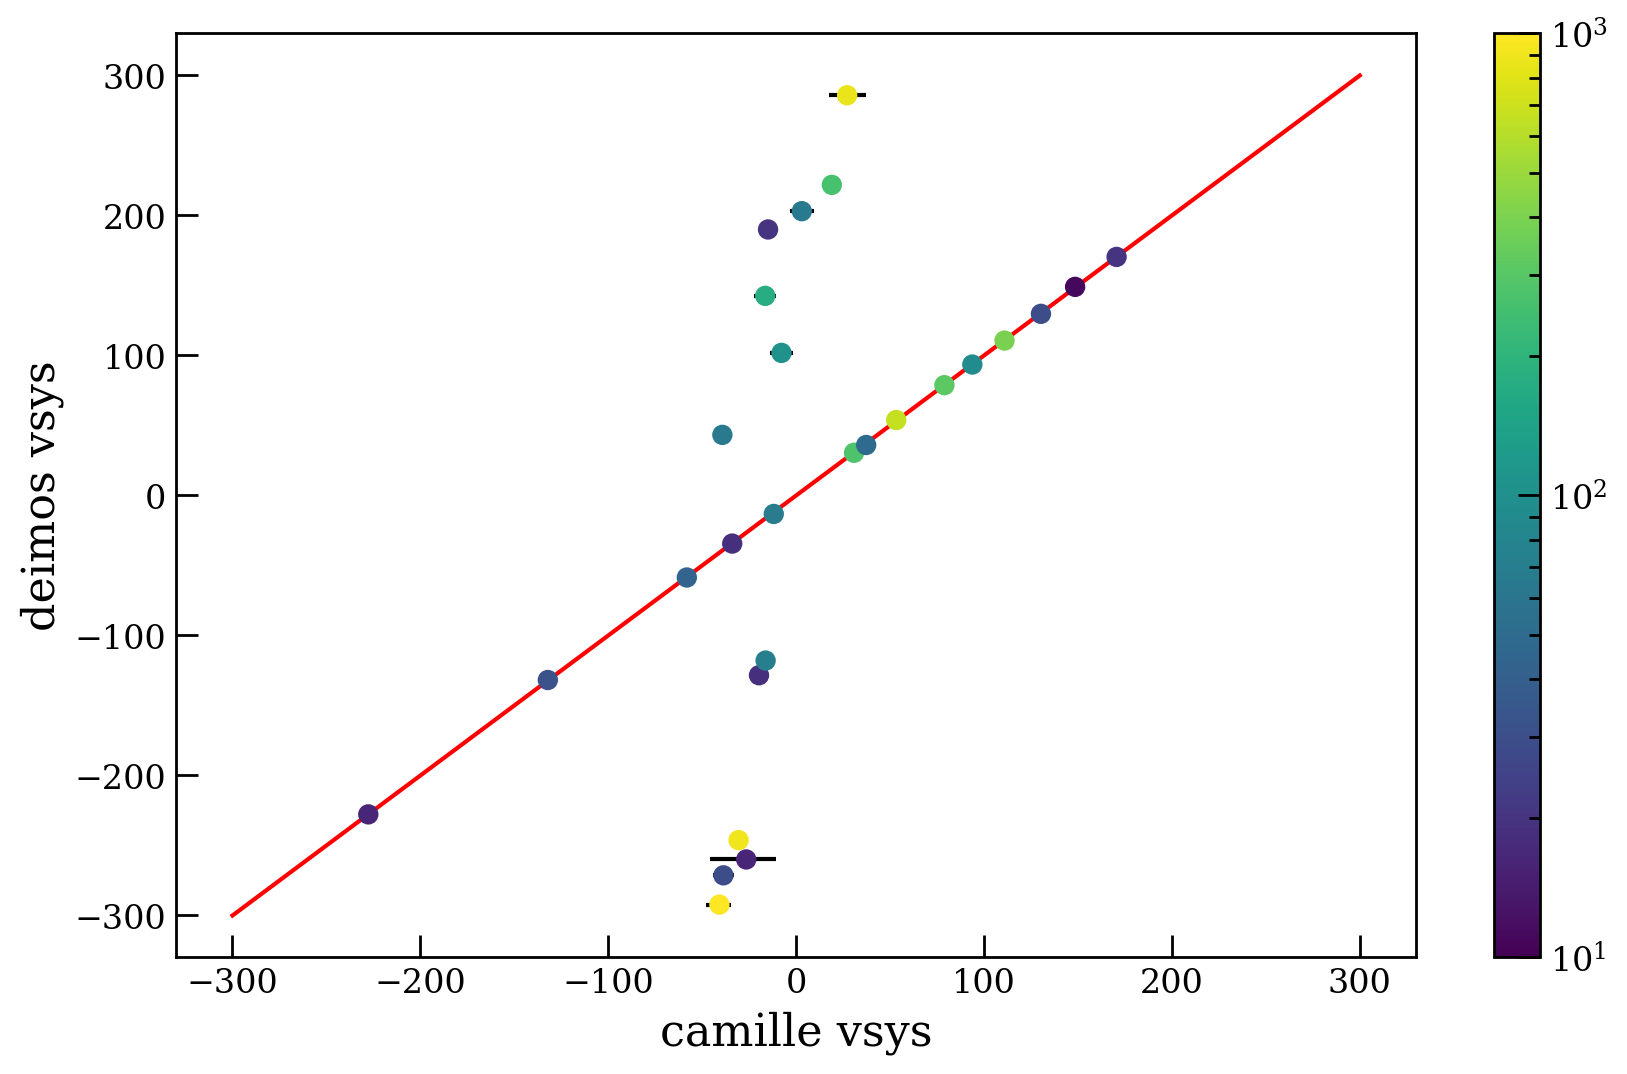

In [399]:
plt.errorbar(systems["3vsys"], systems["vhel"], xerr = np.array([systems["3vsys_ep"], systems["3vsys_em"]]), 
             yerr = systems["vhelerr"], fmt = "o", c = "black", ms = 2, zorder = 0)
plt.scatter(systems["3vsys"], systems["vhel"], c = systems["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([-300, 300], [-300, 300], c = "red", zorder = 0)
plt.xlabel("camille vsys")
plt.ylabel("deimos vsys")
plt.colorbar()

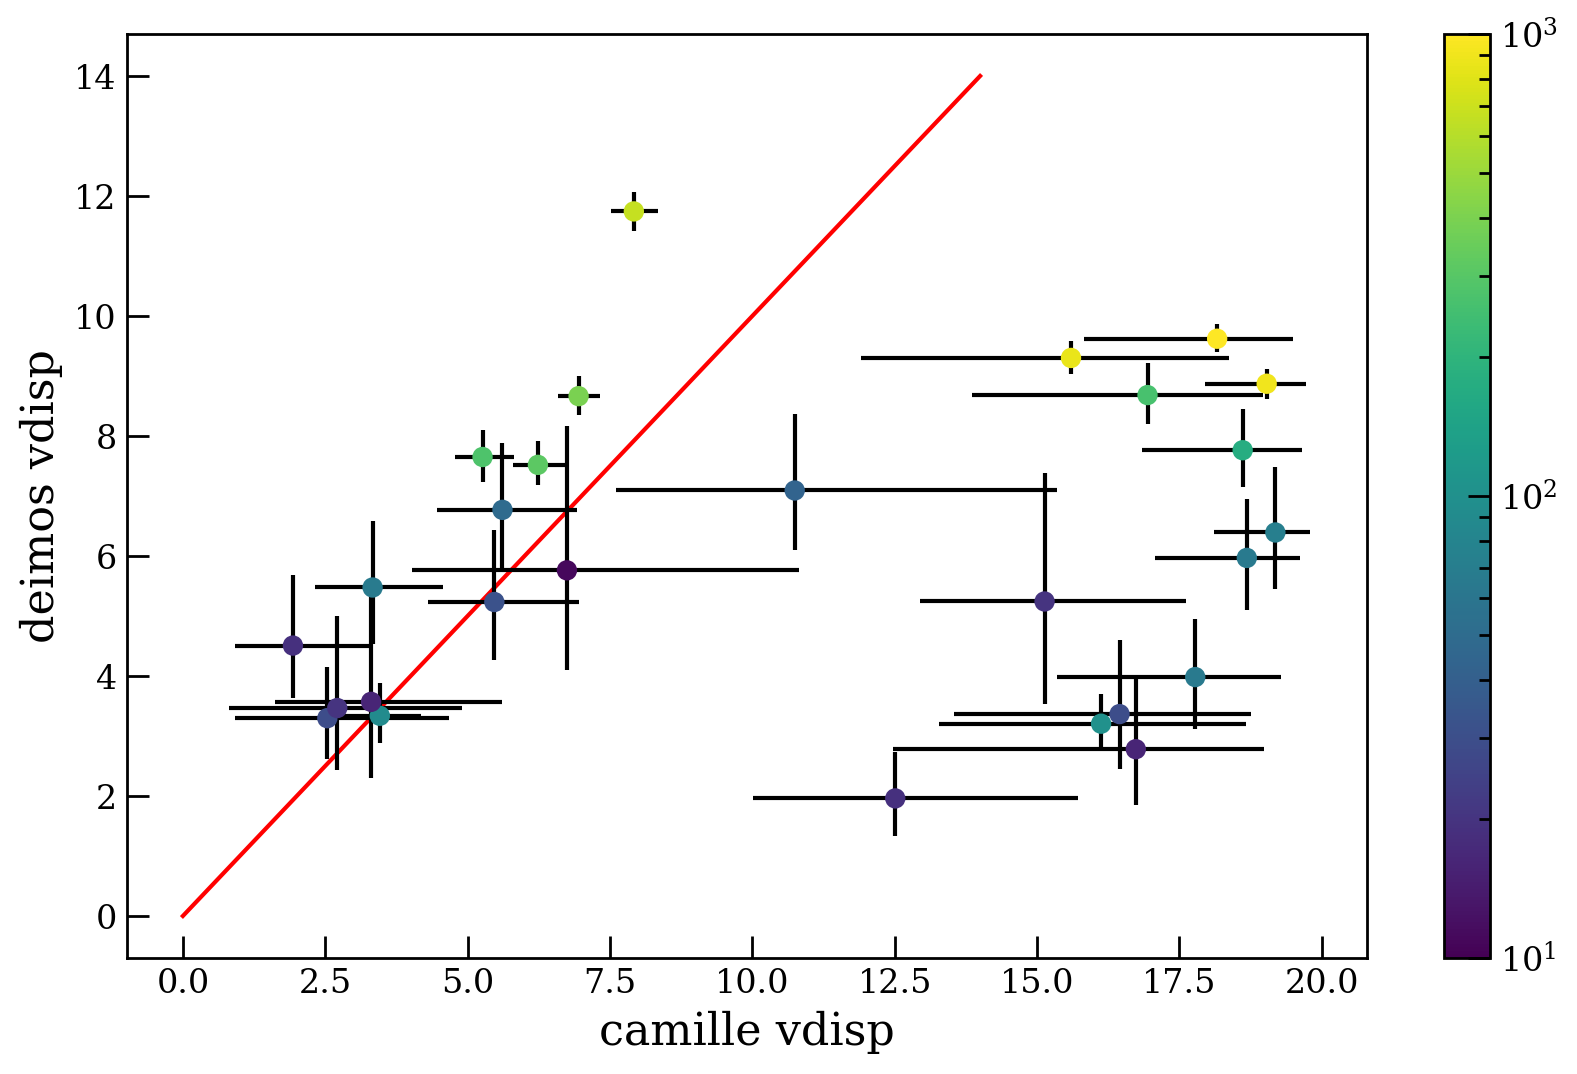

In [400]:
plt.errorbar(systems["3vdisp"], systems["sigma"], xerr = np.array([systems["3vdisp_ep"], systems["3vdisp_em"]]), 
             yerr = np.array([systems["serr_low"], systems["serr_up"]]), fmt = "o", c = "black", ms = 2, zorder = 1)
plt.scatter(systems["3vdisp"], systems["sigma"], c = systems["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([0, 14], [0, 14], c = "red", zorder = 0)
plt.xlabel("camille vdisp")
plt.ylabel("deimos vdisp")
plt.colorbar()

### 4. Adding velocity variables

In [ ]:
gal = stars_epochs[(stars_epochs["rhalf"] <= 2) & (stars_epochs["Pmem"] >= 0.5)]
model, trace, summaries = utils.velocity_binary(vels=gal["mask_v"], v_errs=gal["mask_v_err"], galaxy_ids=gal["Galaxy_idx"], 
                                                star_ids=gal["s_idx"], draws=4000, tune=2000)

In [555]:
sigma_v = summaries["sigma_v_percentiles_per_galaxy"][:, 1]
sigma_v_err = np.array([sigma_v - summaries["sigma_v_percentiles_per_galaxy"][:, 0],
                        summaries["sigma_v_percentiles_per_galaxy"][:, 2] - sigma_v])

vr = summaries["v_r_percentiles_per_galaxy"][:, 1]
vr_err = np.array([vr - summaries["v_r_percentiles_per_galaxy"][:, 0],
                   summaries["v_r_percentiles_per_galaxy"][:, 2] - vr])

f_binary = summaries["f_bin_percentiles_per_galaxy"][:, 1]
f_binary_err = np.array([f_binary - summaries["f_bin_percentiles_per_galaxy"][:, 0],
                        summaries["f_bin_percentiles_per_galaxy"][:, 2] - f_binary])

sigma_bin = summaries["sigma_bin_percentiles_per_galaxy"][:, 1]
sigma_bin_err = np.array([sigma_bin - summaries["sigma_bin_percentiles_per_galaxy"][:, 0],
                        summaries["sigma_bin_percentiles_per_galaxy"][:, 2] - sigma_bin])

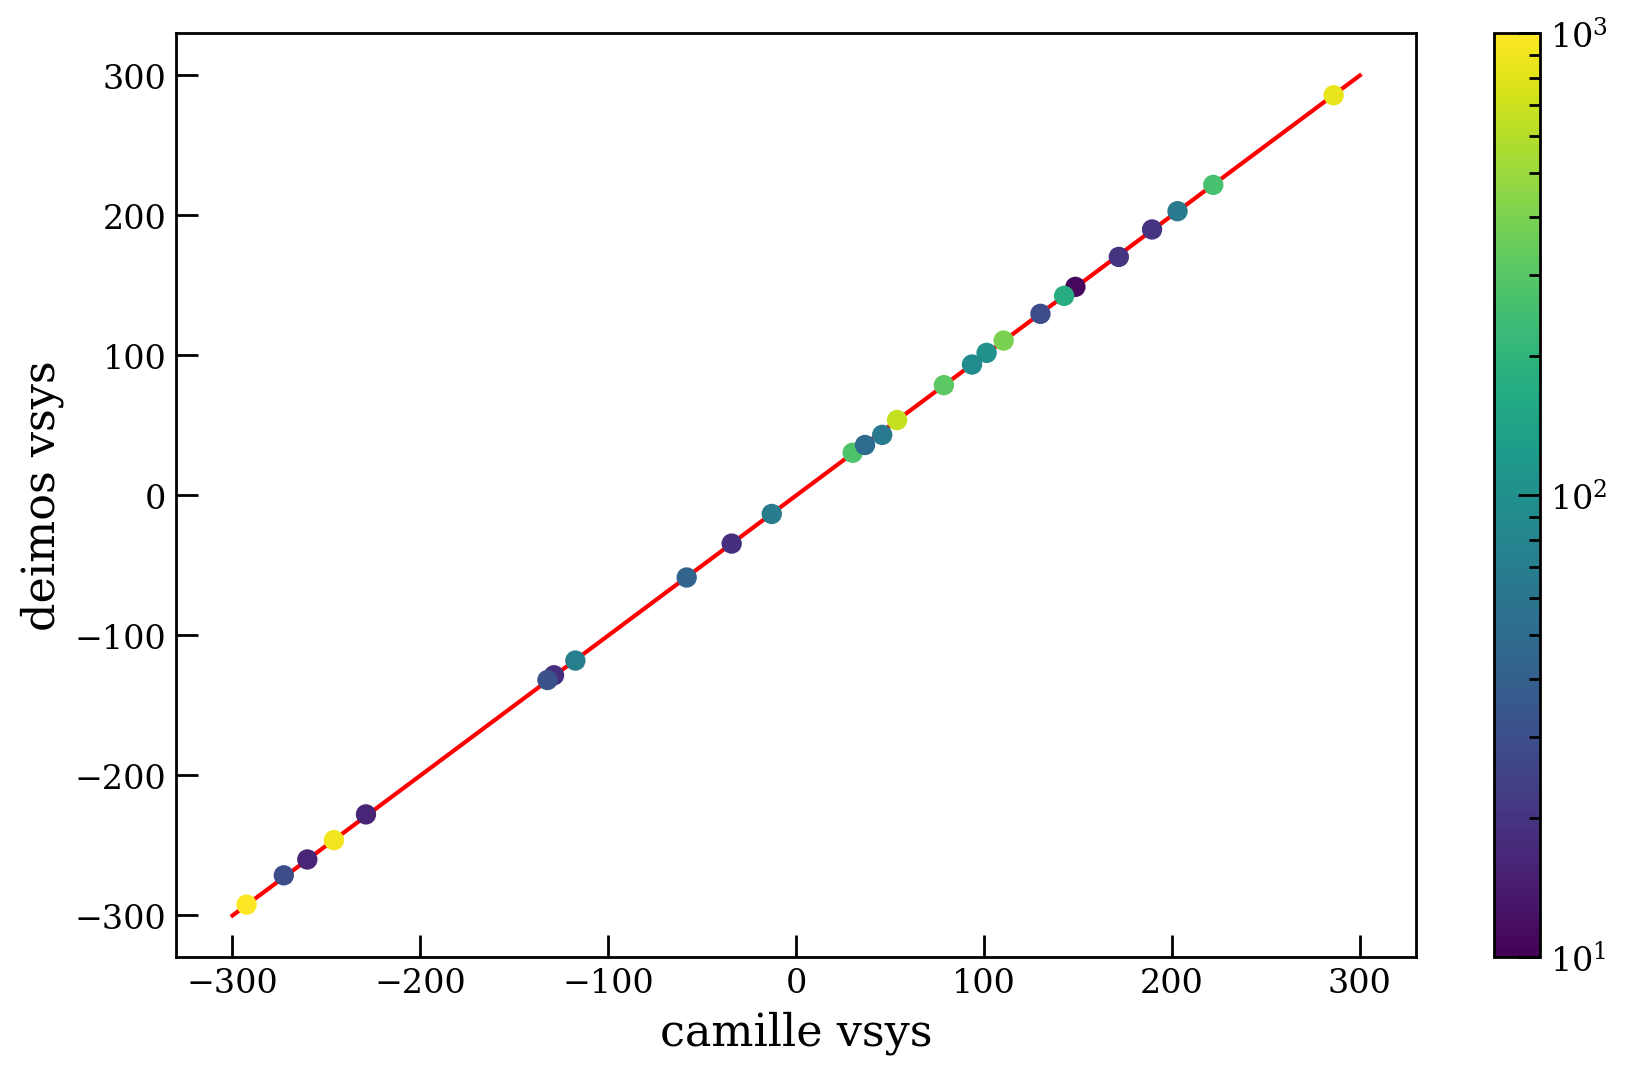

In [ ]:
plt.errorbar(vr, systems["vhel"], xerr = vr_err, 
             yerr = systems["vhelerr"], fmt = "o", c = "grey", ms = 2, zorder = 0)
plt.scatter(vr, systems["vhel"], c = systems["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([-300, 300], [-300, 300], c = "red", zorder = 0)
plt.xlabel("camille vsys")
plt.ylabel("deimos vsys")
plt.colorbar()

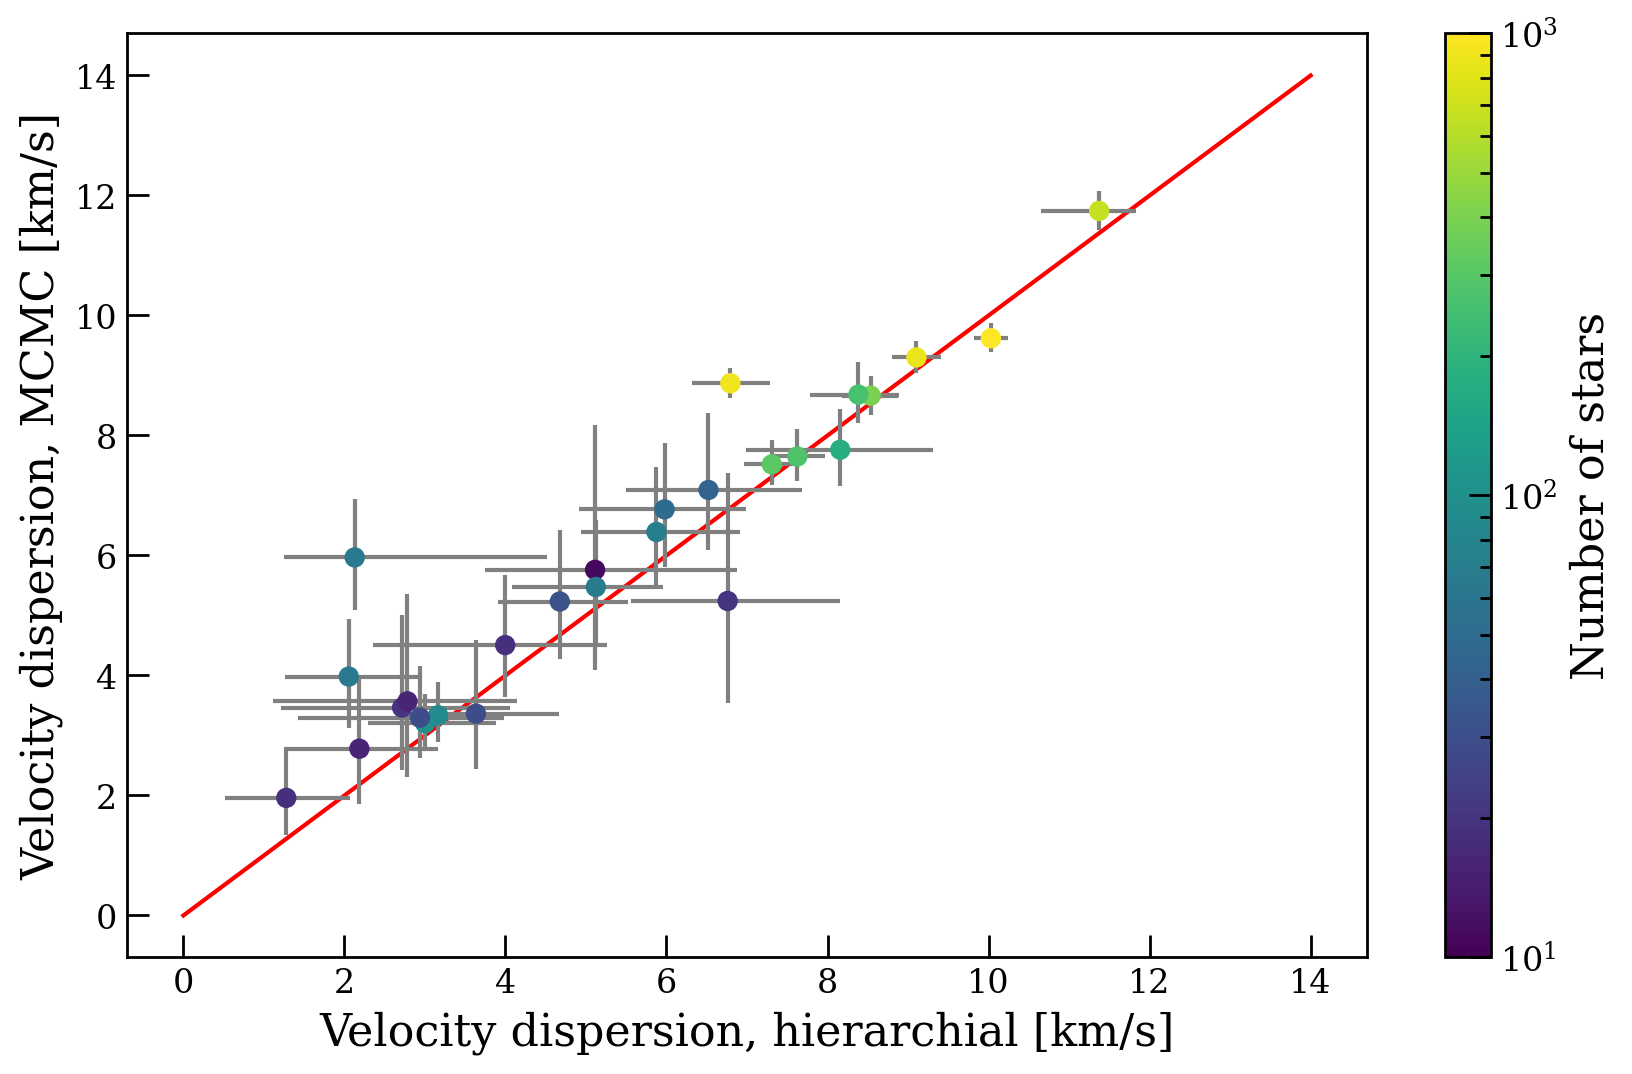

In [569]:
plt.errorbar(sigma_v, systems["sigma"], xerr = sigma_v_err, 
             yerr = np.array([systems["serr_low"], systems["serr_up"]]), fmt = "o", c = "grey", ms = 2, zorder = 1)
plt.scatter(sigma_v, systems["sigma"], c = systems["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([0, 14], [0, 14], c = "red", zorder = 0)
plt.xlabel("Velocity dispersion, hierarchial [km/s]")
plt.ylabel("Velocity dispersion, MCMC [km/s]")
plt.colorbar(label = "Number of stars", location = "right")

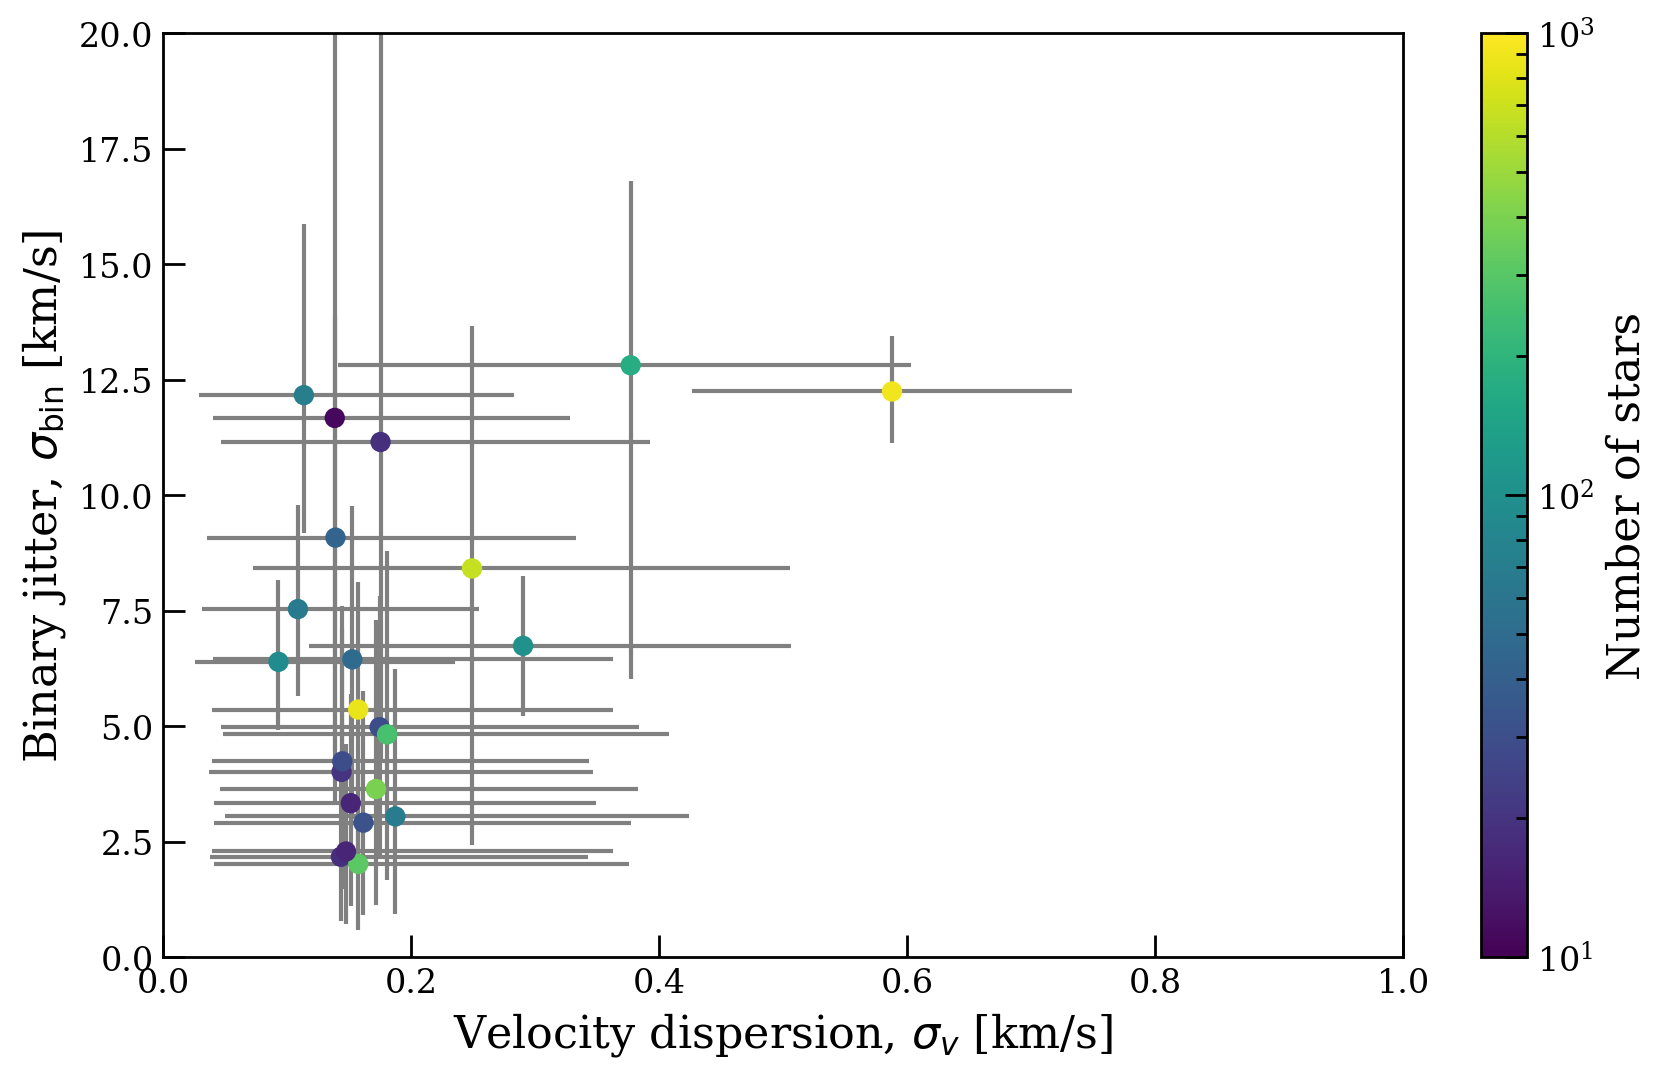

In [567]:
plt.errorbar(f_binary, sigma_bin, xerr = f_binary_err, 
             yerr = sigma_bin_err, fmt = "o", c = "grey", ms = 2, zorder = 1)
plt.scatter(f_binary, sigma_bin, c = systems["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.xlim(0, 1)
plt.ylim(0, 20)
plt.xlabel(r"Velocity dispersion, $\sigma_v$ [km/s]")
plt.ylabel(r"Binary jitter, $\sigma_{\rm bin}$ [km/s]")
plt.colorbar(label = "Number of stars", location = "right")

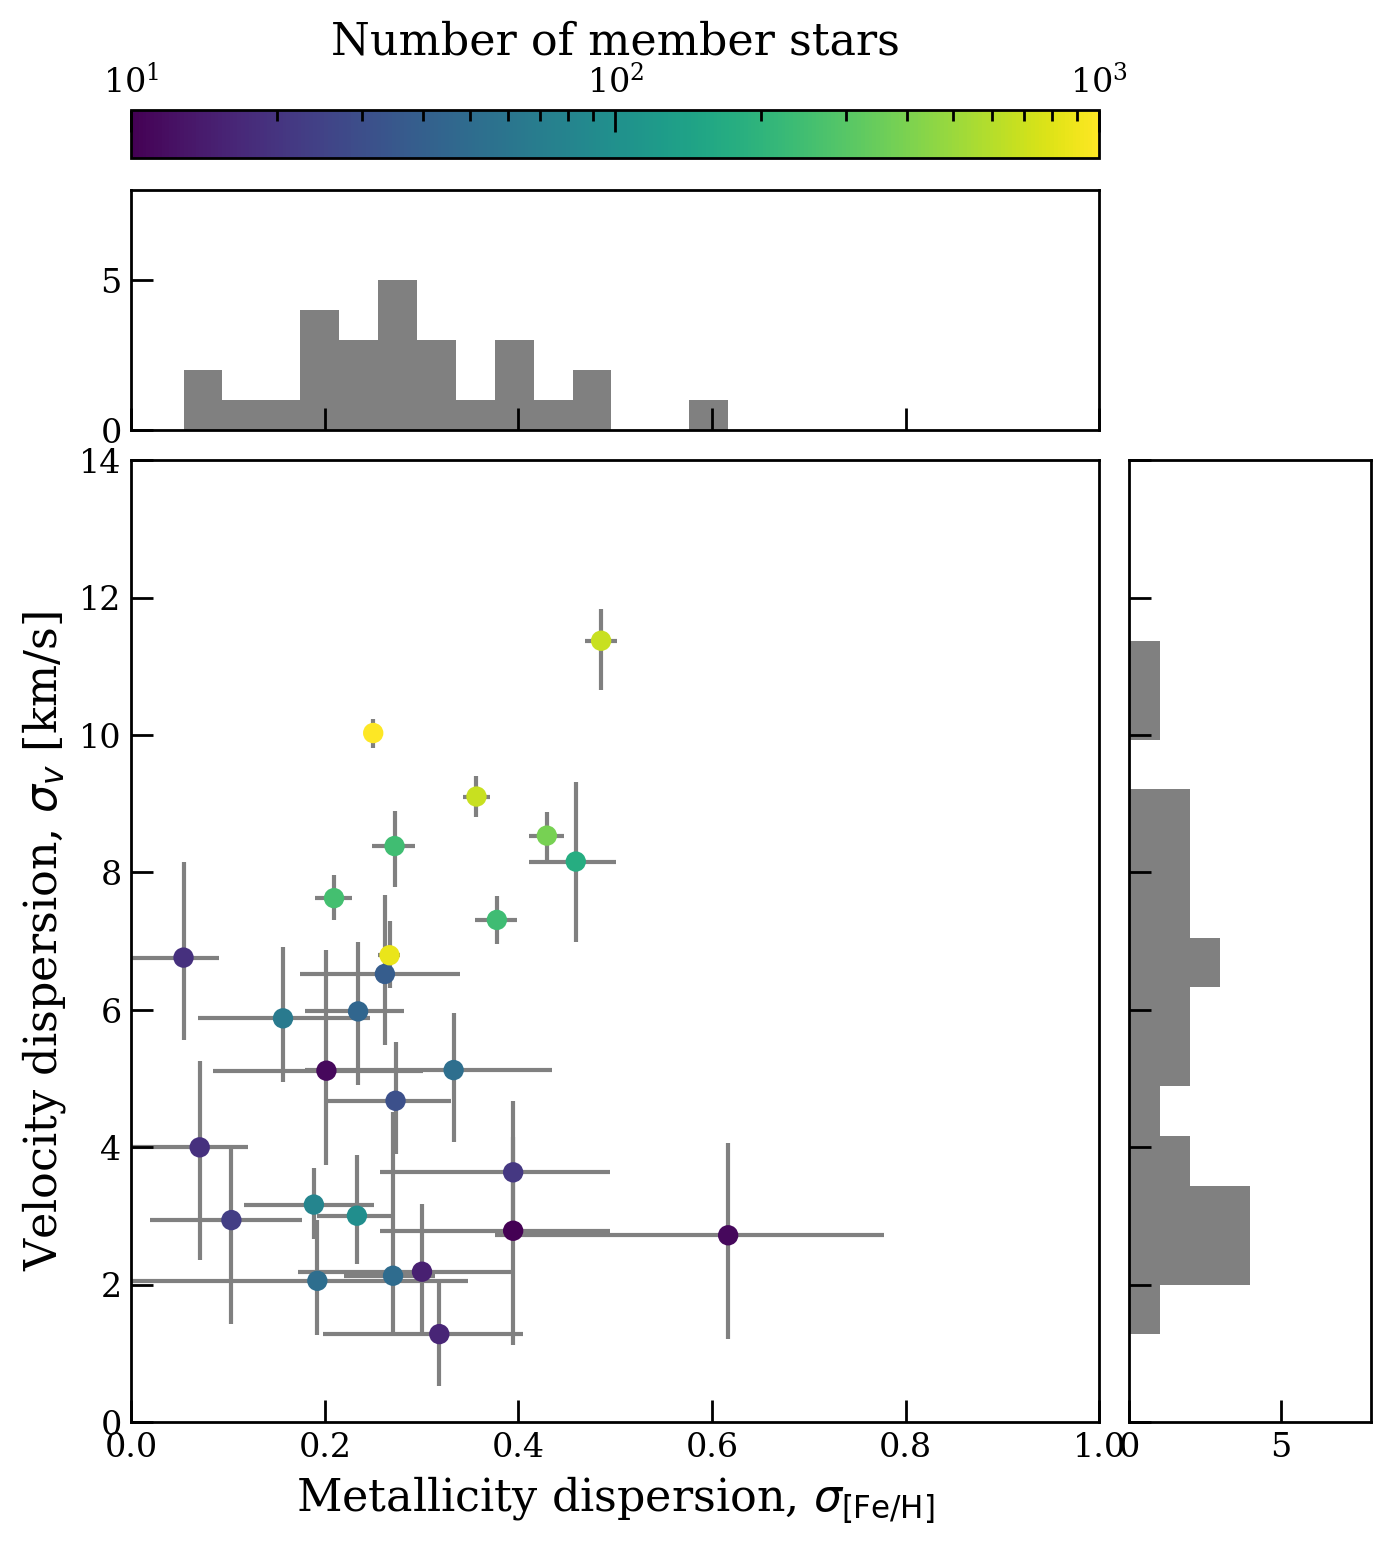

In [594]:
# figure
fig, ax = plt.subplots(2, 2, figsize = (8, 8), gridspec_kw = {"width_ratios": [4, 1], "height_ratios": [1, 4], "wspace": 0.05, "hspace": 0.05})
ax[0, 1].axis("off")
ax[0, 0].sharex(ax[1, 0])
ax[1, 1].sharey(ax[1, 0])

# scatter
ax[1, 0].errorbar(systems["fehdisp_1"], sigma_v, xerr = np.array([systems["fehdisp_1ep"], systems["fehdisp_1em"]]), 
                  yerr = sigma_v_err, fmt = "o", c = "grey", ms = 2, zorder = 0)
data = ax[1, 0].scatter(systems["fehdisp_1"], sigma_v, c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), s = 40, zorder = 1)

ax[1, 0].set_xlabel(r"Metallicity dispersion, $\sigma_{\rm [Fe/H]}$")
ax[1, 0].set_ylabel(r"Velocity dispersion, $\sigma_v$ [km/s]")
ax[1, 0].set_xlim(0, 1)
ax[1, 0].set_ylim(0, 14)

# histogram
ax[0, 0].hist(systems["fehdisp_1"], bins = 14, color = "grey")
ax[1, 1].hist(sigma_v, bins = 14, orientation = "horizontal", color = "grey")
plt.setp(ax[0, 0].get_xticklabels(), visible = False)
plt.setp(ax[1, 1].get_yticklabels(), visible = False)

ax[0, 0].set_ylim(0, 8)
ax[1, 1].set_xlim(0, 8)

pos = ax[0, 0].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y1 + 0.02, pos.width, 0.03])
cb = fig.colorbar(data, cax = cbar_ax, orientation = "horizontal")
cb.set_label("Number of member stars")
cb.ax.xaxis.set_label_position("top")
cb.ax.xaxis.tick_top()

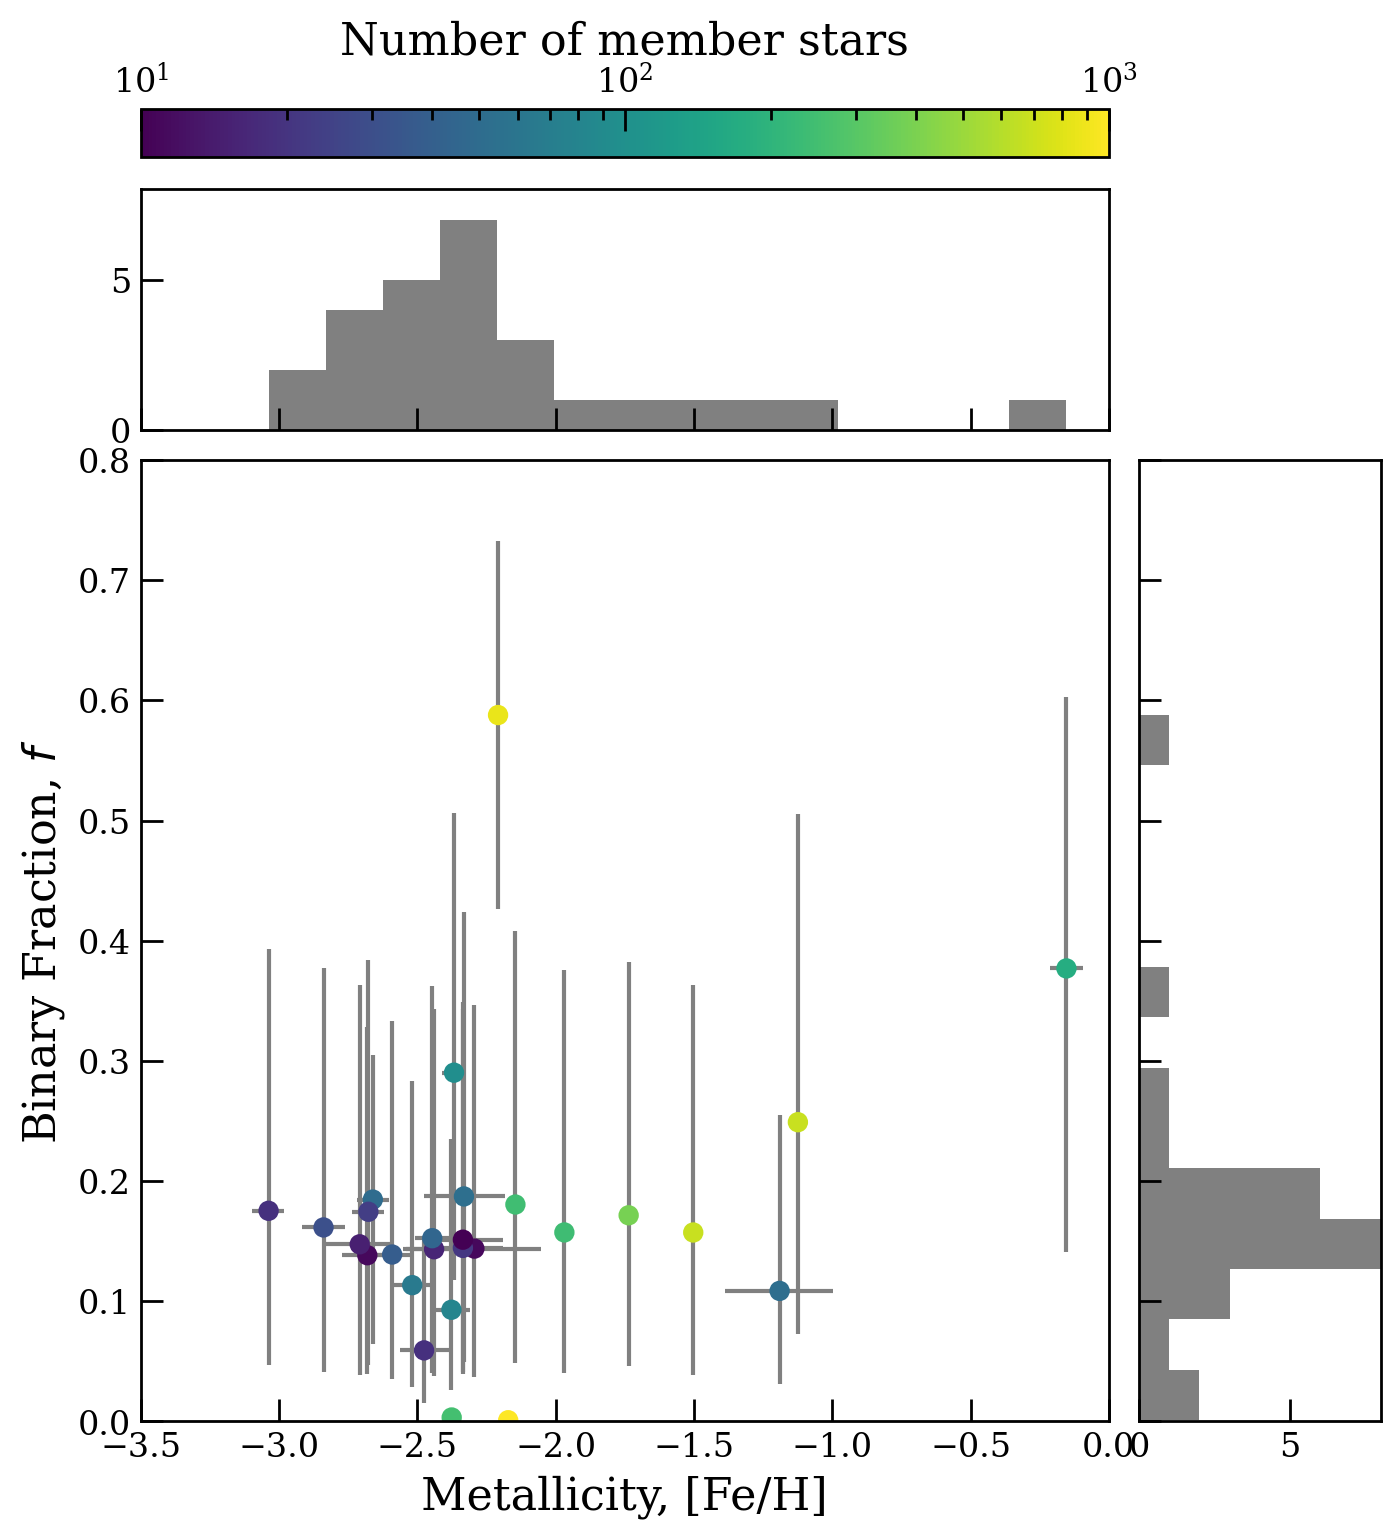

In [595]:
# figure
fig, ax = plt.subplots(2, 2, figsize = (8, 8), gridspec_kw = {"width_ratios": [4, 1], "height_ratios": [1, 4], "wspace": 0.05, "hspace": 0.05})
ax[0, 1].axis("off")
ax[0, 0].sharex(ax[1, 0])
ax[1, 1].sharey(ax[1, 0])

# scatter
ax[1, 0].errorbar(systems["feh_1"], f_binary, xerr = np.array([systems["feh_1ep"], systems["feh_1em"]]), 
                  yerr = f_binary_err, fmt = "o", c = "grey", ms = 2, zorder = 0)
data = ax[1, 0].scatter(systems["feh_1"], f_binary, c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), s = 40, zorder = 1)

ax[1, 0].set_xlabel(r"Metallicity, [Fe/H]")
ax[1, 0].set_ylabel(r"Binary Fraction, $f$")
ax[1, 0].set_xlim(-3.5, 0)
ax[1, 0].set_ylim(0, 0.8)

# histogram
ax[0, 0].hist(systems["feh_1"], bins = 14, color = "grey")
ax[1, 1].hist(f_binary, bins = 14, orientation = "horizontal", color = "grey")
plt.setp(ax[0, 0].get_xticklabels(), visible = False)
plt.setp(ax[1, 1].get_yticklabels(), visible = False)

ax[0, 0].set_ylim(0, 8)
ax[1, 1].set_xlim(0, 8)

pos = ax[0, 0].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y1 + 0.02, pos.width, 0.03])
cb = fig.colorbar(data, cax = cbar_ax, orientation = "horizontal")
cb.set_label("Number of member stars")
cb.ax.xaxis.set_label_position("top")
cb.ax.xaxis.tick_top()

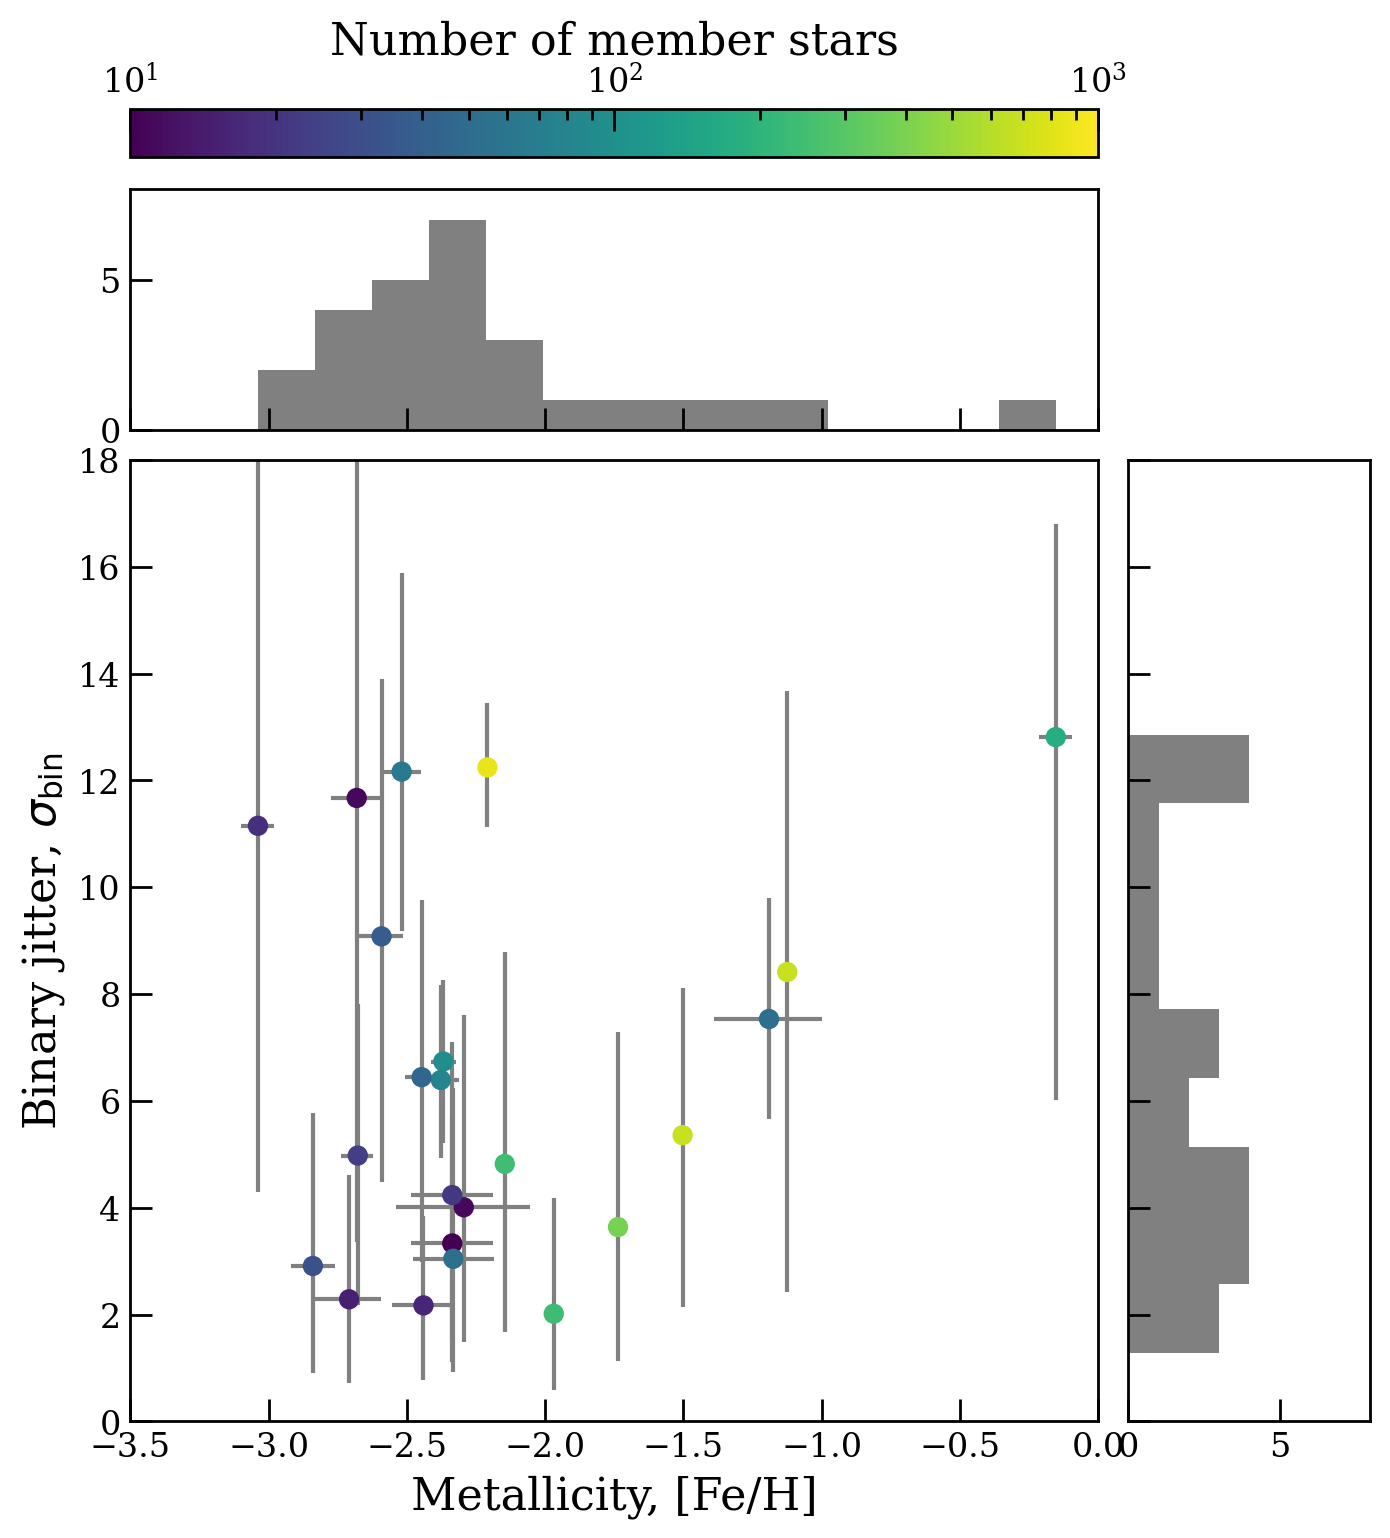

In [596]:
# figure
fig, ax = plt.subplots(2, 2, figsize = (8, 8), gridspec_kw = {"width_ratios": [4, 1], "height_ratios": [1, 4], "wspace": 0.05, "hspace": 0.05})
ax[0, 1].axis("off")
ax[0, 0].sharex(ax[1, 0])
ax[1, 1].sharey(ax[1, 0])

# scatter
ax[1, 0].errorbar(systems["feh_1"], sigma_bin, xerr = np.array([systems["feh_1ep"], systems["feh_1em"]]), 
                  yerr = sigma_bin_err, fmt = "o", c = "grey", ms = 2, zorder = 0)
data = ax[1, 0].scatter(systems["feh_1"], sigma_bin, c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), s = 40, zorder = 1)

ax[1, 0].set_xlabel(r"Metallicity, [Fe/H]")
ax[1, 0].set_ylabel(r"Binary jitter, $\sigma_{\rm bin}$")
ax[1, 0].set_xlim(-3.5, 0)
ax[1, 0].set_ylim(0, 18)

# histogram
ax[0, 0].hist(systems["feh_1"], bins = 14, color = "grey")
ax[1, 1].hist(sigma_bin, bins = 14, range = [0, 18], orientation = "horizontal", color = "grey")
plt.setp(ax[0, 0].get_xticklabels(), visible = False)
plt.setp(ax[1, 1].get_yticklabels(), visible = False)

ax[0, 0].set_ylim(0, 8)
ax[1, 1].set_xlim(0, 8)

pos = ax[0, 0].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y1 + 0.02, pos.width, 0.03])
cb = fig.colorbar(data, cax = cbar_ax, orientation = "horizontal")
cb.set_label("Number of member stars")
cb.ax.xaxis.set_label_position("top")
cb.ax.xaxis.tick_top()

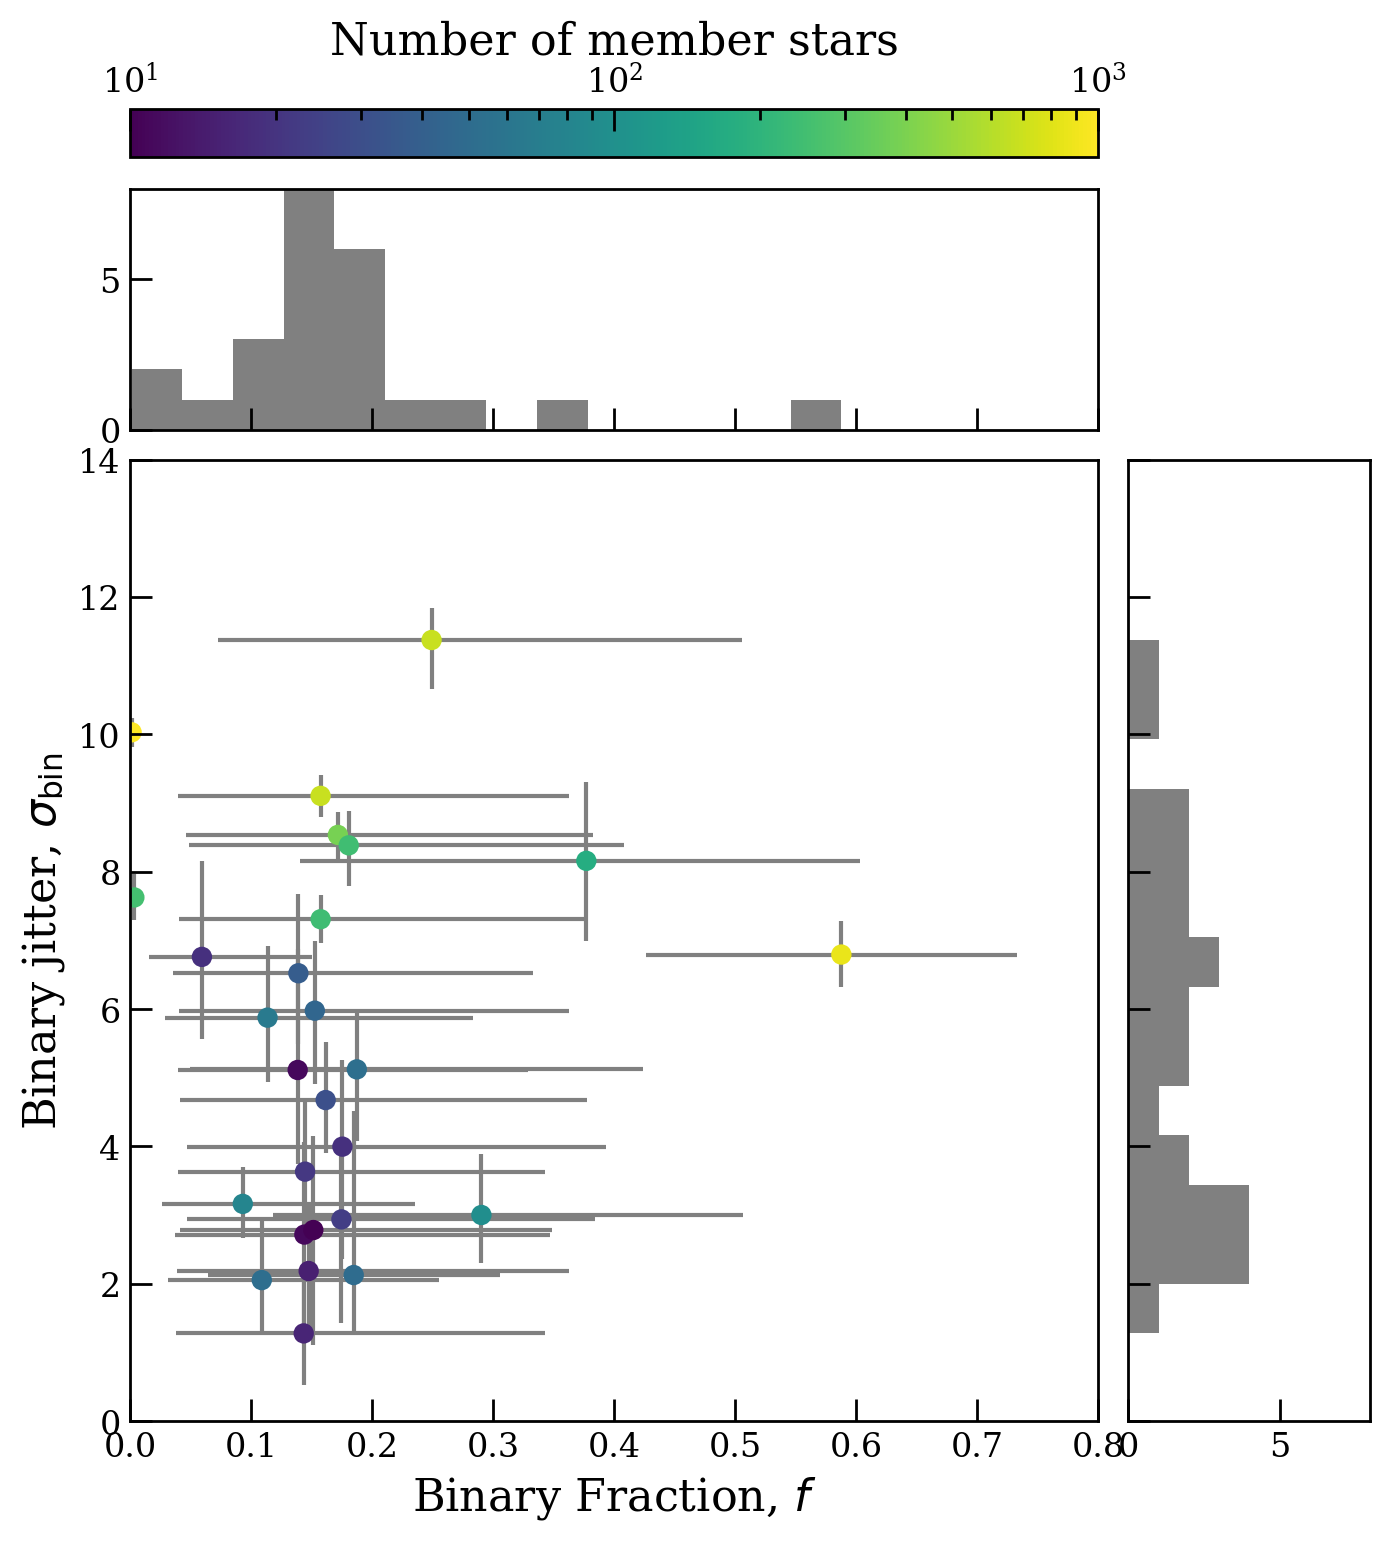

In [597]:
# figure
fig, ax = plt.subplots(2, 2, figsize = (8, 8), gridspec_kw = {"width_ratios": [4, 1], "height_ratios": [1, 4], "wspace": 0.05, "hspace": 0.05})
ax[0, 1].axis("off")
ax[0, 0].sharex(ax[1, 0])
ax[1, 1].sharey(ax[1, 0])

# scatter
ax[1, 0].errorbar(f_binary, sigma_v, xerr = f_binary_err, 
                  yerr = sigma_v_err, fmt = "o", c = "grey", ms = 2, zorder = 0)
data = ax[1, 0].scatter(f_binary, sigma_v, c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), s = 40, zorder = 1)

ax[1, 0].set_xlabel(r"Binary Fraction, $f$")
ax[1, 0].set_ylabel(r"Binary jitter, $\sigma_{\rm bin}$")
ax[1, 0].set_xlim(0, 0.8)
ax[1, 0].set_ylim(0, 14)

# histogram
ax[0, 0].hist(f_binary, bins = 14, color = "grey")
ax[1, 1].hist(sigma_v, bins = 14, orientation = "horizontal", color = "grey")
plt.setp(ax[0, 0].get_xticklabels(), visible = False)
plt.setp(ax[1, 1].get_yticklabels(), visible = False)

ax[0, 0].set_ylim(0, 8)
ax[1, 1].set_xlim(0, 8)

pos = ax[0, 0].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y1 + 0.02, pos.width, 0.03])
cb = fig.colorbar(data, cax = cbar_ax, orientation = "horizontal")
cb.set_label("Number of member stars")
cb.ax.xaxis.set_label_position("top")
cb.ax.xaxis.tick_top()